In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
##################################################################################
##### Define all parameters for model tuning
##################################################################################

n_fold = 5
expName = "NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain"
outPath = "Results"
foldName = "folds.pickle"

epochs = 100
batch_size = 64
shuffle = True
seed = None

input_data_folder = "Data"
training_data_file = "Training-datasets-PredNTS.txt"
independent_data_file = "independent dataset-PredNTS.txt"

In [3]:
import os 
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_auc_score, matthews_corrcoef, classification_report

import math

import matplotlib.pyplot as plt

In [4]:
# print(tf.test.is_gpu_available(cuda_only=True))
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
##################################################################################
##### define all CUSTOM functions
##################################################################################

def one_hot_encode_nt(sequence, char_dict):
    
    seq_encoded = np.zeros((len(sequence),len(char_dict)))
    
    i = 0
    for single_character in sequence:
        if(single_character.upper() in char_dict.keys()):
            seq_encoded[i][char_dict[single_character.upper()]] = 1
            i = i+1
        else:
            raise ValueError('Incorrect character in NT sequence: '+sequence)
    return seq_encoded

In [6]:
##################################################################################
##### Build k-fold functions
##################################################################################

## Build the K-fold from dataset
def build_kfold(features, labels, k=10, shuffle=False, seed=None):
    
    skf = StratifiedKFold(n_splits=k, shuffle=shuffle, random_state=seed)
    kfoldList = []
    for train_index, test_index in skf.split(features, labels):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        kfoldList.append({
            "X_train": X_train,
            "X_test": X_test,
            "y_train":y_train,
            "y_test":y_test
        })
    return kfoldList

In [7]:
##################################################################################
##### define evaluator functions
##################################################################################

def pred2label(y_pred):
    y_pred = np.round(y_pred)
    return y_pred

def labels_1d_to_2d(labels_1d):
    labels_2d = np.eye(2)[labels_1d]
    return labels_2d

# Model

In [8]:
# ##################################################################################
# ##### Function to customize the DLNN architecture with parameters
# ##################################################################################

# def DLNN_CORENup(input_seq_shape = (41, 21),
#                  conv_filters_per_layer_1 = 50, kernel_length_1 = 5, conv_strides_1 = 1, ## 1st Convolutional layer parameters
#                  max_pool_width_1 = 2, max_pool_stride_1 = 2, ## 1st Maxpool layer parameters
#                  lstm_decode_units = 50, ## LSTM layer parameters
#                  conv_filters_per_layer_2 = 50,  kernel_length_2 = 10, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
#                  max_pool_width_2 = 2, max_pool_stride_2 = 2, ## 2nd Maxpool layer parameters
#                  dense_decode_units = 370, ## Dense layer parameters
#                  prob = 0.5, learn_rate = 0.0003, loss = 'binary_crossentropy', metrics = None):
    
#     beta = 0.005
    
#     ######################################################################################################
#     ########  SEQUENCE  ##################################################################################
#     ######################################################################################################
    
#     input1 = tf.keras.layers.Input(shape=input_seq_shape)

#     x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
#                                 strides = conv_strides_1, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = "same")(input1)
#     x1 = tf.keras.layers.Activation('relu')(x1)
#     x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
#     x1 = tf.keras.layers.Dropout(prob)(x1)

#     ## LSTM Path

#     x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
#     x2 = tf.keras.layers.Dropout(prob)(x2)
    
#     x2 = tf.keras.layers.Flatten()(x2)

#     ## Conv Path

#     x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, 
#                                 strides = conv_strides_2, 
#                                 kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                                 padding = 'same')(x1)
#     x3 = tf.keras.layers.Activation('relu')(x3)
#     x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
#     x3 = tf.keras.layers.Dropout(prob)(x3)
    
#     x3 = tf.keras.layers.Flatten()(x3)
    
#     x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
#     ######################################################################################################
#     ########  Classifier  ################################################################################
#     ######################################################################################################
    
#     y = tf.keras.layers.Dense(dense_decode_units, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'relu')(x4)
    
#     y = tf.keras.layers.Dropout(prob)(y)
    
#     y = tf.keras.layers.Dense(1, 
#                               kernel_regularizer = tf.keras.regularizers.l2(beta), 
#                               activation = 'sigmoid')(y)

#     ## Generate Model from input and output
#     model = tf.keras.models.Model(inputs=input1, outputs=y)
    
#     ## Compile model
#     if(metrics != None):
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
#                       loss = loss, metrics = metrics)
#     else:
#         model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), 
#                       loss = loss)

#     return model

In [9]:
##################################################################################
##### Function to customize the DLNN architecture with parameters
##################################################################################

def DLNN_CORENup(input_seq_shape = (41, 21),
                 conv_filters_per_layer_1 = 10, kernel_length_1 = 10, conv_strides_1 = 1, ## 1st Convolutional layer parameters
                 max_pool_width_1 = 3, max_pool_stride_1 = 3, ## 1st Maxpool layer parameters
                 lstm_decode_units = 10, ## LSTM layer parameters
                 conv_filters_per_layer_2 = 10,  kernel_length_2 = 5, conv_strides_2 = 1, ## 2nd Convolutional layer parameters
                 max_pool_width_2 = 3, max_pool_stride_2 = 3, ## 2nd Maxpool layer parameters
                 dense_decode_units = 32, ## Dense layer parameters
                 prob = 0.5, learn_rate = 0.0005, 
                 loss = 'binary_crossentropy', metrics = None):
    
    beta = 0.005
    
    ######################################################################################################
    ########  SEQUENCE  ##################################################################################
    ######################################################################################################
    
    input1 = tf.keras.layers.Input(shape=input_seq_shape)

    x1 = tf.keras.layers.Conv1D(conv_filters_per_layer_1, kernel_length_1,
                                strides = conv_strides_1, kernel_regularizer = tf.keras.regularizers.l2(beta), 
                                padding = "same")(input1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.MaxPool1D(pool_size = max_pool_width_1, strides = max_pool_stride_1)(x1)
    x1 = tf.keras.layers.Dropout(prob)(x1)

    ## LSTM Path

    x2 = tf.keras.layers.LSTM(lstm_decode_units, return_sequences = True, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta))(x1)
    
    x2 = tf.keras.layers.Dropout(prob)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)

    ## Conv Path

    x3 = tf.keras.layers.Conv1D(conv_filters_per_layer_2, kernel_length_2, strides = conv_strides_2, 
                                kernel_regularizer = tf.keras.regularizers.l2(beta), padding = 'same')(x1)
    x3 = tf.keras.layers.Activation('relu')(x3)
    x3 = tf.keras.layers.MaxPooling1D(pool_size = max_pool_width_2, strides = max_pool_stride_2)(x3)
    x3 = tf.keras.layers.Dropout(prob)(x3)
    
    x3 = tf.keras.layers.Flatten()(x3)
    
    x4 = tf.keras.layers.Concatenate(1)([x2,x3])
    
    ######################################################################################################
    ########  Classifier  ################################################################################
    ######################################################################################################
    
    y = tf.keras.layers.Dense(dense_decode_units, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta), 
                              activation = 'relu')(x4)
    
    y = tf.keras.layers.Dropout(prob)(y)
    
    y = tf.keras.layers.Dense(1, 
                              kernel_regularizer = tf.keras.regularizers.l2(beta),
                              activation = 'sigmoid')(y)

    ## Generate Model from input and output
    model = tf.keras.models.Model(inputs=input1, outputs=y)
    
    ## Compile model
    if(metrics != None):
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss, metrics = metrics)
    else:
        model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=learn_rate), loss = loss)

    return model

In [10]:
DLNN_CORENup().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 41, 21)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 41, 10)       2110        ['input_1[0][0]']                
                                                                                                  
 activation (Activation)        (None, 41, 10)       0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 13, 10)       0           ['activation[0][0]']             
                                                                                              

# Read Data

In [11]:
##################################################################################
##### read training file
##################################################################################
train_file_path = os.path.join(input_data_folder, training_data_file)
train_data = pd.read_csv(train_file_path, sep='\t', header=None)
train_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Independent Dataset

In [12]:
##################################################################################
##### read independent data file
##################################################################################
indpe_file_path = os.path.join(input_data_folder, independent_data_file)
indpe_data = pd.read_csv(indpe_file_path, sep='\t', header=None)
indpe_data.columns = ['Sequence', 'name', 'id', 'flag', 'label_original', 'type']

# Exploratory Data Analysis

In [13]:
# empty char count per sequence
train_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in train_data['Sequence']]
# incomplete sequence flag
train_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in train_data['Sequence']]

indpe_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in indpe_data['Sequence']]
indpe_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in indpe_data['Sequence']]

In [14]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

### Train

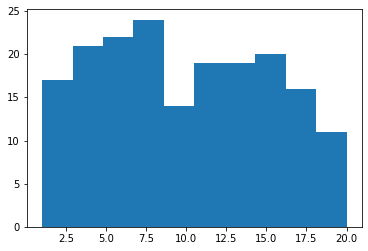

Total empty records: 183
Ratio empty/total: 0.07682619647355164


In [15]:
plt.hist(train_data['Empty_count'][train_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(train_data['has_empty']))
print('Ratio empty/total:', sum(train_data['has_empty'])/train_data.shape[0])

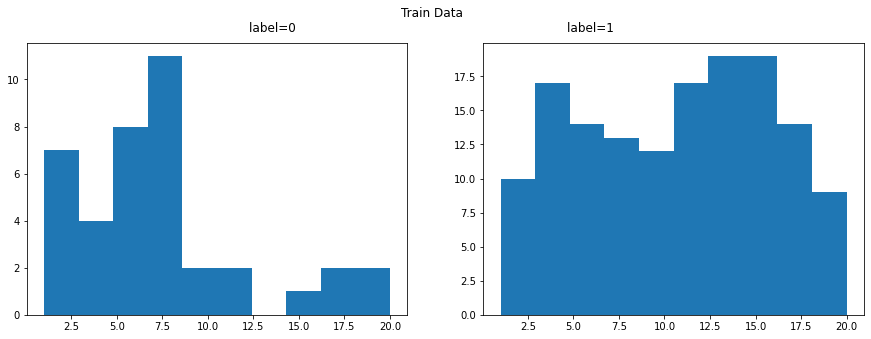

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == -1)])
axs[1].hist(train_data['Empty_count'][(train_data['Empty_count'] != 0) & (train_data['label_original'] == 1)])
plt.show()

In [17]:
train_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()

,label_original,has_empty
0,-1,39
1,1,144


### independent

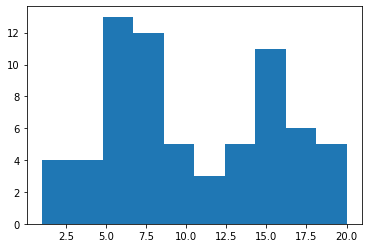

Total empty records: 68
Ratio empty/total: 0.05551020408163265


In [18]:
plt.hist(indpe_data['Empty_count'][indpe_data['Empty_count'] != 0])
plt.show()
print('Total empty records:', sum(indpe_data['has_empty']))
print('Ratio empty/total:', sum(indpe_data['has_empty'])/indpe_data.shape[0])

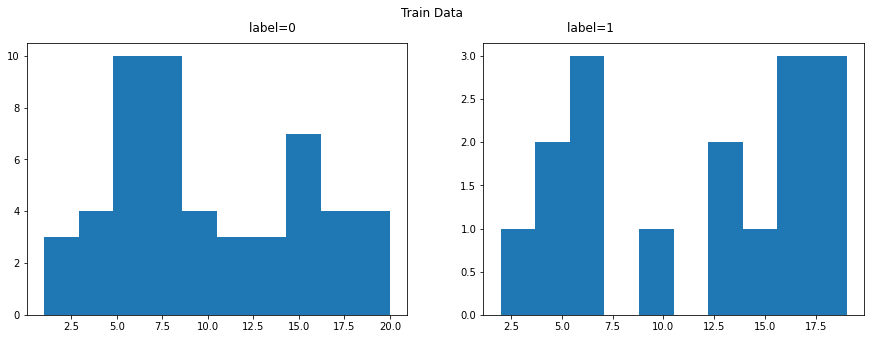

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Train Data\nlabel=0                                                                      label=1')
axs[0].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == -1)])
axs[1].hist(indpe_data['Empty_count'][(indpe_data['Empty_count'] != 0) & (indpe_data['label_original'] == 1)])
plt.show()

In [20]:
indpe_data.groupby(["label_original"]).sum().filter(['has_empty'])

,has_empty
label_original,
-1,52
1,16


In [21]:
_,_ = print_and_get_stats(train_data, indpe_data)

Current train_label_nonempty_ratio: 0.2708333333333333 train_label_ratio: 1.0
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


# Data Augmentation on Training dataset

In [22]:
import random

def sequence_truncate(seq, random_length):
    rep_str = "".join(['-']*random_length)
    if np.random.choice((True, False)):
        return_seq = rep_str + seq[random_length:]
    else:
        return_seq = seq[:-random_length] + rep_str
    return return_seq

def random_sequence_truncate(seq):
    random_length = np.random.randint(1, 20)
    return_seq = sequence_truncate(seq, random_length)
    return return_seq

def repeat_truncate_sequence_steps(seq, factor):
    random_length = random.sample(range(1, int(len(seq)/2)), 
                                  factor)
    return_seqs = []
    for i in range(factor):
        ret_seq = sequence_truncate(seq, random_length[i])
        return_seqs.append(ret_seq)
    return return_seqs

In [23]:
def print_and_get_stats(source_data, target_data):
    
    # empty char count per sequence
    source_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in source_data['Sequence']]
    # incomplete sequence flag
    source_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in source_data['Sequence']]
    
    target_data['Empty_count'] = [np.sum(np.array(list(val)) == '-') for val in target_data['Sequence']]
    target_data['has_empty'] = [True if np.sum(np.array(list(val)) == '-') > 0 else False for val in target_data['Sequence']]

    # 0:1
    train_label_nonempty_ratio = source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / source_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    train_label_ratio = (source_data.shape[0]-sum(source_data["label_original"] == 1)) / sum(source_data["label_original"] == 1)

    # 0:1
    indpe_label_nonempty_ratio = target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][0] / target_data.groupby(["label_original"]).sum().filter(['has_empty']).reset_index()['has_empty'][1]
    indpe_label_ratio = (target_data.shape[0]-sum(target_data["label_original"] == 1)) / sum(target_data["label_original"] == 1)

    print('Current train_label_nonempty_ratio:', train_label_nonempty_ratio, 'train_label_ratio:', train_label_ratio)
    print('Target indpe_label_nonempty_ratio:', indpe_label_nonempty_ratio, 'indpe_label_ratio:', indpe_label_ratio)

    increase_0_data_factor = int(round(indpe_label_ratio/train_label_ratio)) - 1
    increase_empty_data_factor = int(round(indpe_label_nonempty_ratio/train_label_nonempty_ratio)) - 1
    
    return increase_0_data_factor, increase_empty_data_factor

In [24]:
# train_data = train_data_backup

########

factor = 1
data = train_data
# neg_data = data[data['label_original'] == -1].reset_index(drop=True)
neg_data = data.reset_index(drop=True)

not_empty_idxs = np.where(neg_data['has_empty'] != True)[0]

for idx in not_empty_idxs:
    record = neg_data.iloc[idx].to_dict()
    
    seqs = repeat_truncate_sequence_steps(record['Sequence'], factor)
    
    for seq in seqs:
        record['Sequence'] = seq
        neg_data = neg_data.append(record, ignore_index=True)

final_data = pd.concat((neg_data, data))
print(final_data.shape)

##########################

_ , _ = print_and_get_stats(final_data, indpe_data)

##########################

final_data = final_data.drop_duplicates().reset_index(drop=True)
print(final_data.shape)

print('\n##### After removing duplicates #####\n')
##########

_ , _ = print_and_get_stats(final_data, indpe_data)

(6963, 8)
Current train_label_nonempty_ratio: 0.9213483146067416 train_label_ratio: 1.0306211723534557
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895
(4581, 8)

##### After removing duplicates #####

Current train_label_nonempty_ratio: 1.0 train_label_ratio: 1.0469168900804289
Target indpe_label_nonempty_ratio: 3.25 indpe_label_ratio: 5.0344827586206895


##  Final preparations for training data

In [25]:
train_data = final_data

##################################################################################
##### Create dictionary of all characters in the NT sequence 
##################################################################################
all_char_set = set({})
for val in [set(val) for val in train_data['Sequence']]:
    all_char_set = all_char_set.union(val)
all_char_list = list(all_char_set)
all_char_list.sort()
all_char_dict = {}
for i in range(len(all_char_list)):
    all_char_dict[all_char_list[i]] = i
    
##################################################################################
##### Create OHE of sequence
##################################################################################
train_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in train_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
train_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in train_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

train_features = np.array(list(train_data['OHE_Sequence']))
train_labels = np.array(list(train_data['label']))
train_labels = train_labels.reshape((train_labels.shape[0], 1))

input_seq_shape = train_features[0].shape

folds = build_kfold(train_features, train_labels, k=n_fold, shuffle=shuffle, seed=seed)

## Write the k-fold dataset to file
foldPath = os.path.join(outPath, expName, "{}fold".format(n_fold))
if(not os.path.isdir(foldPath)):
    os.makedirs(foldPath)
pickle.dump(folds, open(os.path.join(foldPath, foldName), "wb"))

# Final prep for Independent dataset

In [26]:
##################################################################################
##### Create OHE of sequence
##################################################################################
indpe_data['OHE_Sequence'] = pd.Series([one_hot_encode_nt(val, all_char_dict) 
                                        for val in indpe_data["Sequence"]])

##################################################################################
##### Fix the labels
##################################################################################
indpe_data['label'] = pd.Series([1 if val == 1 else 0 
                                 for val in indpe_data["label_original"]])

##################################################################################
##### Extract features and labels, create folds
##################################################################################

indpe_features = np.array(list(indpe_data['OHE_Sequence']))
indpe_labels = np.array(list(indpe_data['label']))
indpe_labels = indpe_labels.reshape((indpe_labels.shape[0], 1))

input_seq_shape = indpe_features[0].shape

# Training

In [27]:
##################################################################################
##### For each input file, train model and generate different outputs in a structured folder
##################################################################################

## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Train/Test model on all folds, generate evaluations
##################################################################################

## Create and set directory to save model
modelPath = os.path.join(outPath, expName, "{}fold".format(n_fold), "models")
if(not os.path.isdir(modelPath)):
    os.makedirs(modelPath)

i = -1
for fold in folds:
    i += 1
    
    print("\nTrain/Test model on Fold #"+str(i)+".")
    
    model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
    ## Define the model callbacks for early stopping and saving the model. Then train model
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    modelCallbacks = [
        tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                           monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                           save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
    ]
    
    # adding random shuffling of the dataset for training purpose
    index_arr = np.arange(fold["X_train"].shape[0])
    index_arr = np.random.permutation(index_arr)
    
    model.fit(x = fold["X_train"][index_arr], y = fold["y_train"][index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
              callbacks = modelCallbacks, validation_data = (fold["X_test"], fold["y_test"]))
    
    model = tf.keras.models.load_model(current_model_path)
    
    ##################################################################################
    ##### Prediction and metrics for TRAIN dataset
    ##################################################################################

    y_pred = model.predict(fold["X_train"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_train"], label_pred)
    prec = precision_score(fold["y_train"],label_pred)
    mcc = matthews_corrcoef(fold["y_train"], label_pred)

    conf = confusion_matrix(fold["y_train"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_train"], y_pred)
    auc = roc_auc_score(fold["y_train"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Train")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)
    
    ##################################################################################
    ##### Prediction and metrics for TEST dataset
    ##################################################################################

    y_pred = model.predict(fold["X_test"])
    label_pred = pred2label(y_pred)
    
    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(fold["y_test"], label_pred)
    prec = precision_score(fold["y_test"],label_pred)
    mcc = matthews_corrcoef(fold["y_test"], label_pred)

    conf = confusion_matrix(fold["y_test"], label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(fold["y_test"], y_pred)
    auc = roc_auc_score(fold["y_test"], y_pred)
    
    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Test")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)


Train/Test model on Fold #0.
Epoch 1/100
58/58 [==============================] - ETA: 0s - loss: 1.1452
Epoch 1: val_loss improved from inf to 1.08208, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 6s 17ms/step - loss: 1.1452 - val_loss: 1.0821
Epoch 2/100
54/58 [==========================>...] - ETA: 0s - loss: 1.0551
Epoch 2: val_loss improved from 1.08208 to 1.00930, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 1.0531 - val_loss: 1.0093
Epoch 3/100
57/58 [============================>.] - ETA: 0s - loss: 0.9839
Epoch 3: val_loss improved from 1.00930 to 0.95044, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] -

58/58 [==============================] - 0s 9ms/step - loss: 0.5150 - val_loss: 0.5169
Epoch 26/100
58/58 [==============================] - ETA: 0s - loss: 0.5086
Epoch 26: val_loss improved from 0.51688 to 0.50835, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 0s 8ms/step - loss: 0.5086 - val_loss: 0.5083
Epoch 27/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4973
Epoch 27: val_loss improved from 0.50835 to 0.49837, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4987 - val_loss: 0.4984
Epoch 28/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4949
Epoch 28: val_loss improved from 0.49837 to 0.49076, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\m

58/58 [==============================] - 1s 9ms/step - loss: 0.4109 - val_loss: 0.4323
Epoch 53/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4207
Epoch 53: val_loss improved from 0.43228 to 0.43016, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4206 - val_loss: 0.4302
Epoch 54/100
57/58 [============================>.] - ETA: 0s - loss: 0.4148
Epoch 54: val_loss did not improve from 0.43016
58/58 [==============================] - 0s 8ms/step - loss: 0.4151 - val_loss: 0.4350
Epoch 55/100
57/58 [============================>.] - ETA: 0s - loss: 0.4199
Epoch 55: val_loss improved from 0.43016 to 0.42633, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4196 - val_loss: 0.4263
Epoch 56/100
55/5

Epoch 83/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3662
Epoch 83: val_loss did not improve from 0.39491
58/58 [==============================] - 0s 8ms/step - loss: 0.3679 - val_loss: 0.4005
Epoch 84/100
57/58 [============================>.] - ETA: 0s - loss: 0.3650
Epoch 84: val_loss did not improve from 0.39491
58/58 [==============================] - 0s 8ms/step - loss: 0.3650 - val_loss: 0.4057
Epoch 85/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3737
Epoch 85: val_loss did not improve from 0.39491
58/58 [==============================] - 0s 8ms/step - loss: 0.3747 - val_loss: 0.4005
Epoch 86/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3763
Epoch 86: val_loss improved from 0.39491 to 0.39347, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold0.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.3739 - val_loss: 0.3935
Epoch 87/100
55/58 [==

58/58 [==============================] - 1s 9ms/step - loss: 0.6448 - val_loss: 0.6332
Epoch 12/100
55/58 [===========================>..] - ETA: 0s - loss: 0.6375
Epoch 12: val_loss improved from 0.63316 to 0.62376, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.6372 - val_loss: 0.6238
Epoch 13/100
55/58 [===========================>..] - ETA: 0s - loss: 0.6297
Epoch 13: val_loss improved from 0.62376 to 0.61533, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.6290 - val_loss: 0.6153
Epoch 14/100
52/58 [=========================>....] - ETA: 0s - loss: 0.6156
Epoch 14: val_loss improved from 0.61533 to 0.60653, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\mo

54/58 [==========================>...] - ETA: 0s - loss: 0.4797
Epoch 37: val_loss did not improve from 0.50127
58/58 [==============================] - 0s 8ms/step - loss: 0.4785 - val_loss: 0.5043
Epoch 38/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4524
Epoch 38: val_loss improved from 0.50127 to 0.49234, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4524 - val_loss: 0.4923
Epoch 39/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4582
Epoch 39: val_loss did not improve from 0.49234
58/58 [==============================] - 0s 8ms/step - loss: 0.4603 - val_loss: 0.4999
Epoch 40/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4630
Epoch 40: val_loss did not improve from 0.49234
58/58 [==============================] - 0s 8ms/step - loss: 0.4647 - val_loss: 0.4958
Epoch 41/100
55/58 [===============

58/58 [==============================] - 0s 8ms/step - loss: 0.3903 - val_loss: 0.4526
Epoch 67/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3962
Epoch 67: val_loss improved from 0.44180 to 0.43972, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.3954 - val_loss: 0.4397
Epoch 68/100
56/58 [===========================>..] - ETA: 0s - loss: 0.3882
Epoch 68: val_loss did not improve from 0.43972
58/58 [==============================] - 0s 8ms/step - loss: 0.3882 - val_loss: 0.4486
Epoch 69/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3795
Epoch 69: val_loss did not improve from 0.43972
58/58 [==============================] - 0s 8ms/step - loss: 0.3796 - val_loss: 0.4418
Epoch 70/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3863
Epoch 70: val_loss did not improve from 0.43972
58/58 [===============

57/58 [============================>.] - ETA: 0s - loss: 0.3711
Epoch 100: val_loss improved from 0.42250 to 0.42053, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold1.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.3699 - val_loss: 0.4205

Train/Test model on Fold #2.
Epoch 1/100
52/58 [=========================>....] - ETA: 0s - loss: 1.1465
Epoch 1: val_loss improved from inf to 1.07648, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 2s 16ms/step - loss: 1.1414 - val_loss: 1.0765
Epoch 2/100
54/58 [==========================>...] - ETA: 0s - loss: 1.0482
Epoch 2: val_loss improved from 1.07648 to 1.00579, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/st

58/58 [==============================] - 1s 9ms/step - loss: 0.5394 - val_loss: 0.5369
Epoch 25/100
53/58 [==========================>...] - ETA: 0s - loss: 0.5293
Epoch 25: val_loss improved from 0.53690 to 0.53437, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.5309 - val_loss: 0.5344
Epoch 26/100
53/58 [==========================>...] - ETA: 0s - loss: 0.5212
Epoch 26: val_loss improved from 0.53437 to 0.51777, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.5212 - val_loss: 0.5178
Epoch 27/100
54/58 [==========================>...] - ETA: 0s - loss: 0.5230
Epoch 27: val_loss did not improve from 0.51777
58/58 [==============================] - 0s 8ms/step - loss: 0.5251 - val_loss: 0.5294
Epoch 28/100
54/5

58/58 [==============================] - 1s 9ms/step - loss: 0.4405 - val_loss: 0.4481
Epoch 52/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4350
Epoch 52: val_loss did not improve from 0.44810
58/58 [==============================] - 0s 8ms/step - loss: 0.4332 - val_loss: 0.4493
Epoch 53/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4254
Epoch 53: val_loss improved from 0.44810 to 0.44619, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4254 - val_loss: 0.4462
Epoch 54/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4218
Epoch 54: val_loss did not improve from 0.44619
58/58 [==============================] - 0s 8ms/step - loss: 0.4226 - val_loss: 0.4466
Epoch 55/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4389
Epoch 55: val_loss improved from 0.44619 to 0.44158, saving model to R

58/58 [==============================] - 1s 9ms/step - loss: 0.3956 - val_loss: 0.4056
Epoch 81/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4036
Epoch 81: val_loss improved from 0.40562 to 0.40261, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4003 - val_loss: 0.4026
Epoch 82/100
55/58 [===========================>..] - ETA: 0s - loss: 0.3950
Epoch 82: val_loss did not improve from 0.40261
58/58 [==============================] - 0s 8ms/step - loss: 0.3981 - val_loss: 0.4039
Epoch 83/100
53/58 [==========================>...] - ETA: 0s - loss: 0.3854
Epoch 83: val_loss improved from 0.40261 to 0.40195, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold2.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.3873 - val_loss: 0.4019
Epoch 84/100
54/5

58/58 [==============================] - 1s 9ms/step - loss: 0.6706 - val_loss: 0.6431
Epoch 11/100
56/58 [===========================>..] - ETA: 0s - loss: 0.6483
Epoch 11: val_loss improved from 0.64308 to 0.63007, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.6483 - val_loss: 0.6301
Epoch 12/100
56/58 [===========================>..] - ETA: 0s - loss: 0.6349
Epoch 12: val_loss improved from 0.63007 to 0.62278, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.6365 - val_loss: 0.6228
Epoch 13/100
57/58 [============================>.] - ETA: 0s - loss: 0.6301
Epoch 13: val_loss improved from 0.62278 to 0.61409, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\mo

Epoch 36/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4655
Epoch 36: val_loss did not improve from 0.49629
58/58 [==============================] - 0s 8ms/step - loss: 0.4664 - val_loss: 0.4990
Epoch 37/100
53/58 [==========================>...] - ETA: 0s - loss: 0.4611
Epoch 37: val_loss improved from 0.49629 to 0.48980, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4614 - val_loss: 0.4898
Epoch 38/100
56/58 [===========================>..] - ETA: 0s - loss: 0.4577
Epoch 38: val_loss improved from 0.48980 to 0.48842, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold3.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4561 - val_loss: 0.4884
Epoch 39/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4697
Epoch 39: val_loss did not 

Epoch 67/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4031
Epoch 67: val_loss did not improve from 0.44891
58/58 [==============================] - 0s 8ms/step - loss: 0.4055 - val_loss: 0.4521
Epoch 68/100
57/58 [============================>.] - ETA: 0s - loss: 0.4122
Epoch 68: val_loss did not improve from 0.44891
58/58 [==============================] - 1s 9ms/step - loss: 0.4122 - val_loss: 0.4517
Epoch 69/100
52/58 [=========================>....] - ETA: 0s - loss: 0.4010
Epoch 69: val_loss did not improve from 0.44891
58/58 [==============================] - 1s 9ms/step - loss: 0.4010 - val_loss: 0.4544
Epoch 70/100
58/58 [==============================] - ETA: 0s - loss: 0.3976
Epoch 70: val_loss did not improve from 0.44891
58/58 [==============================] - 1s 9ms/step - loss: 0.3976 - val_loss: 0.4625
Epoch 71/100
58/58 [==============================] - ETA: 0s - loss: 0.4015
Epoch 71: val_loss did not improve from 0.44891
58/58 [====================

55/58 [===========================>..] - ETA: 0s - loss: 0.3708
Epoch 100: val_loss did not improve from 0.42105
58/58 [==============================] - 0s 8ms/step - loss: 0.3711 - val_loss: 0.4244

Train/Test model on Fold #4.
Epoch 1/100
52/58 [=========================>....] - ETA: 0s - loss: 1.1347
Epoch 1: val_loss improved from inf to 1.06384, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 2s 16ms/step - loss: 1.1296 - val_loss: 1.0638
Epoch 2/100
56/58 [===========================>..] - ETA: 0s - loss: 1.0276
Epoch 2: val_loss improved from 1.06384 to 0.98318, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 11ms/step - loss: 1.0264 - val_loss: 0.9832
Epoch 3/100
56/58 [===========================>..] - ETA: 0s - loss: 0.9541
Epoch 3: val_los

58/58 [==============================] - 1s 10ms/step - loss: 0.5286 - val_loss: 0.5377
Epoch 25/100
52/58 [=========================>....] - ETA: 0s - loss: 0.5183
Epoch 25: val_loss did not improve from 0.53766
58/58 [==============================] - 0s 8ms/step - loss: 0.5238 - val_loss: 0.5392
Epoch 26/100
56/58 [===========================>..] - ETA: 0s - loss: 0.5050
Epoch 26: val_loss improved from 0.53766 to 0.52456, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5074 - val_loss: 0.5246
Epoch 27/100
55/58 [===========================>..] - ETA: 0s - loss: 0.5044
Epoch 27: val_loss improved from 0.52456 to 0.52366, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.5033 - val_loss: 0.5237
Epoch 28/100
5

58/58 [==============================] - 1s 9ms/step - loss: 0.4234 - val_loss: 0.4586
Epoch 53/100
54/58 [==========================>...] - ETA: 0s - loss: 0.4208
Epoch 53: val_loss improved from 0.45857 to 0.45169, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4178 - val_loss: 0.4517
Epoch 54/100
58/58 [==============================] - ETA: 0s - loss: 0.4304
Epoch 54: val_loss did not improve from 0.45169
58/58 [==============================] - 0s 8ms/step - loss: 0.4304 - val_loss: 0.4519
Epoch 55/100
53/58 [==========================>...] - ETA: 0s - loss: 0.4074
Epoch 55: val_loss improved from 0.45169 to 0.44528, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 10ms/step - loss: 0.4058 - val_loss: 0.4453
Epoch 56/100
56

Epoch 86/100
52/58 [=========================>....] - ETA: 0s - loss: 0.3839
Epoch 86: val_loss did not improve from 0.43451
58/58 [==============================] - 1s 9ms/step - loss: 0.3827 - val_loss: 0.4368
Epoch 87/100
54/58 [==========================>...] - ETA: 0s - loss: 0.3758
Epoch 87: val_loss did not improve from 0.43451
58/58 [==============================] - 0s 8ms/step - loss: 0.3786 - val_loss: 0.4353
Epoch 88/100
55/58 [===========================>..] - ETA: 0s - loss: 0.4048
Epoch 88: val_loss improved from 0.43451 to 0.42955, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\bestModel-fold4.hdf5
58/58 [==============================] - 1s 9ms/step - loss: 0.4023 - val_loss: 0.4296
Epoch 89/100
52/58 [=========================>....] - ETA: 0s - loss: 0.3880
Epoch 89: val_loss did not improve from 0.42955
58/58 [==============================] - 0s 9ms/step - loss: 0.3928 - val_loss: 0.4594
Epoch 90/100
58/58 [==

## k-fold Training evaluation

In [28]:
evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Test,0.854615,0.850285,0.926398,0.852981,0.856159,0.709429
Train,0.955414,0.948915,0.988411,0.960569,0.950491,0.910963


In [29]:
evaluations_df[evaluations_df["Train_Test"] == "Test"]

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
1,0,Test,0.864776,0.856828,"[0.0, 0.002232142857142857, 0.2053571428571428...","[0.0, 0.0, 0.0, 0.0021321961620469083, 0.00213...","[1.991244, 0.99124396, 0.9466795, 0.9463727, 0...",0.937595,0.868304,0.861407,0.729555
3,1,Test,0.855895,0.859091,"[0.0, 0.002232142857142857, 0.1049107142857142...","[0.0, 0.0, 0.0, 0.002136752136752137, 0.002136...","[1.9870536, 0.9870536, 0.97027326, 0.9702672, ...",0.918043,0.843750,0.867521,0.711652
5,2,Test,0.849345,0.827004,"[0.0, 0.002232142857142857, 0.1808035714285714...","[0.0, 0.0, 0.0, 0.002136752136752137, 0.002136...","[1.9909499, 0.9909498, 0.95515615, 0.9547177, ...",0.936918,0.875000,0.824786,0.700047
7,3,Test,0.848253,0.856481,"[0.0, 0.0022371364653243847, 0.102908277404921...","[0.0, 0.0, 0.0, 0.0021321961620469083, 0.00213...","[1.9965671, 0.99656713, 0.9780513, 0.97745377,...",0.918173,0.827740,0.867804,0.696467
9,4,Test,0.854803,0.852018,"[0.0, 0.0022371364653243847, 0.096196868008948...","[0.0, 0.0, 0.0, 0.0021321961620469083, 0.00213...","[1.9930145, 0.99301445, 0.96695876, 0.96690774...",0.921261,0.850112,0.859275,0.709426


# Independent data testing

## Using k-fold Models

### Performance of each k-fold model

In [30]:
## create the evaluation data structure for all iterations
evaluations = {
    "Fold" : [],
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    label_pred = pred2label(y_pred)

    # Compute precision, recall, sensitivity, specifity, mcc
    acc = accuracy_score(indpe_labels, label_pred)
    prec = precision_score(indpe_labels,label_pred)
    mcc = matthews_corrcoef(indpe_labels, label_pred)

    conf = confusion_matrix(indpe_labels, label_pred)
    tn, fp, fn, tp = conf.ravel()
    sens = tp/(tp+fn)
    spec = tn/(tn+fp)
    
    fpr, tpr, thresholds = roc_curve(indpe_labels, y_pred)
    auc = roc_auc_score(indpe_labels, y_pred)

    evaluations["Fold"].append(i)
    evaluations["Train_Test"].append("Independent")
    evaluations["Accuracy"].append(acc)
    evaluations["Precision"].append(prec)
    evaluations["TPR"].append(tpr)
    evaluations["FPR"].append(fpr)
    evaluations["TPR_FPR_Thresholds"].append(thresholds)
    evaluations["AUC"].append(auc)
    evaluations["Sensitivity"].append(sens)
    evaluations["Specificity"].append(spec)
    evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.629061,0.247691,0.661831,0.606897,0.633464,0.182131


In [31]:
evaluations_df

,Fold,Train_Test,Accuracy,Precision,TPR,FPR,TPR_FPR_Thresholds,AUC,Sensitivity,Specificity,MCC
0,0,Independent,0.626122,0.251462,"[0.0, 0.0, 0.009852216748768473, 0.00985221674...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9904221, 0.9904221, 0.98561865, 0.97923994,...",0.663256,0.635468,0.624266,0.195751
1,1,Independent,0.634286,0.246377,"[0.0, 0.0049261083743842365, 0.004926108374384...","[0.0, 0.0, 0.0009784735812133072, 0.0009784735...","[1.9852324, 0.98523235, 0.9845371, 0.9842869, ...",0.672544,0.586207,0.643836,0.175027
2,2,Independent,0.604082,0.236940,"[0.0, 0.0, 0.0, 0.009852216748768473, 0.009852...","[0.0, 0.0009784735812133072, 0.002935420743639...","[1.9878273, 0.98782724, 0.9864633, 0.985973, 0...",0.657529,0.625616,0.599804,0.168956
3,3,Independent,0.646531,0.252155,"[0.0, 0.0, 0.0, 0.0049261083743842365, 0.00492...","[0.0, 0.0009784735812133072, 0.002935420743639...","[1.9939371, 0.99393713, 0.9923375, 0.9918413, ...",0.650372,0.576355,0.660470,0.181530
4,4,Independent,0.634286,0.251521,"[0.0, 0.0, 0.0049261083743842365, 0.0049261083...","[0.0, 0.0009784735812133072, 0.000978473581213...","[1.9929299, 0.9929299, 0.98641866, 0.98562336,...",0.665454,0.610837,0.638943,0.189388


### Mean score with k-fold models

In [32]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    total_pred += y_pred
    all_preds.append(y_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.648163,0.263485,0.676752,0.625616,0.652642,0.211789


### Voting score with k-fold models

In [33]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

total_pred = np.zeros(indpe_labels.shape)
all_preds = []

for i in range(n_fold):
    
    current_model_path = os.path.join(modelPath, "bestModel-fold{}.hdf5".format(i))
    model = tf.keras.models.load_model(current_model_path)

    y_pred = model.predict(indpe_features)
    vote_pred = pred2label(y_pred)
    total_pred += vote_pred
    all_preds.append(vote_pred)
    
total_pred = total_pred / n_fold
label_pred = pred2label(total_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels, label_pred)
prec = precision_score(indpe_labels,label_pred)
mcc = matthews_corrcoef(indpe_labels, label_pred)

conf = confusion_matrix(indpe_labels, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels, total_pred)
auc = roc_auc_score(indpe_labels, total_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.645714,0.26087,0.660908,0.62069,0.650685,0.206475


## Using New Model

Train model on full data from training. Predict and evaluate on Independent data.

In [34]:
model = DLNN_CORENup(input_seq_shape = input_seq_shape)
    
## Define the model callbacks for early stopping and saving the model. Then train model
current_model_path = os.path.join(modelPath, "_fullModel.hdf5")
modelCallbacks = [
    tf.keras.callbacks.ModelCheckpoint(current_model_path,
                                       monitor = 'val_loss', verbose = 1, save_best_only = True, 
                                       save_weights_only = False, mode = 'auto', save_freq = 'epoch'),
]

# adding random shuffling of the dataset for training purpose
index_arr = np.arange(train_features.shape[0])
index_arr = np.random.permutation(index_arr)

model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_data = (indpe_features, indpe_labels))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
72/72 [==============================] - ETA: 0s - loss: 1.1258
Epoch 1: val_loss improved from inf to 1.03203, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
72/72 [==============================] - 3s 16ms/step - loss: 1.1258 - val_loss: 1.0320
Epoch 2/100
66/72 [==========================>...] - ETA: 0s - loss: 1.0080
Epoch 2: val_loss improved from 1.03203 to 0.94871, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
72/72 [==============================] - 1s 9ms/step - loss: 1.0046 - val_loss: 0.9487
Epoch 3/100
69/72 [===========================>..] - ETA: 0s - loss: 0.9273
Epoch 3: val_loss improved from 0.94871 to 0.88182, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
72/72 [==============================] - 1s 9ms/step - loss: 0.9261 - val_loss: 0.881

66/72 [==========================>...] - ETA: 0s - loss: 0.4556
Epoch 35: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 9ms/step - loss: 0.4578 - val_loss: 0.8864
Epoch 36/100
72/72 [==============================] - ETA: 0s - loss: 0.4650
Epoch 36: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 9ms/step - loss: 0.4650 - val_loss: 0.8373
Epoch 37/100
67/72 [==========================>...] - ETA: 0s - loss: 0.4646
Epoch 37: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 9ms/step - loss: 0.4618 - val_loss: 0.7974
Epoch 38/100
72/72 [==============================] - ETA: 0s - loss: 0.4573
Epoch 38: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 9ms/step - loss: 0.4573 - val_loss: 0.9021
Epoch 39/100
71/72 [============================>.] - ETA: 0s - loss: 0.4443
Epoch 39: val_loss did not improve from 0.67570
72/72 [==============================] -

Epoch 74/100
72/72 [==============================] - ETA: 0s - loss: 0.4050
Epoch 74: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 8ms/step - loss: 0.4050 - val_loss: 0.9842
Epoch 75/100
70/72 [============================>.] - ETA: 0s - loss: 0.4119
Epoch 75: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 8ms/step - loss: 0.4122 - val_loss: 0.8221
Epoch 76/100
67/72 [==========================>...] - ETA: 0s - loss: 0.3935
Epoch 76: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 8ms/step - loss: 0.3957 - val_loss: 0.8857
Epoch 77/100
69/72 [===========================>..] - ETA: 0s - loss: 0.4012
Epoch 77: val_loss did not improve from 0.67570
72/72 [==============================] - 1s 8ms/step - loss: 0.4031 - val_loss: 0.8439
Epoch 78/100
65/72 [==========================>...] - ETA: 0s - loss: 0.3923
Epoch 78: val_loss did not improve from 0.67570
72/72 [====================

### fine tuning with independent dataset features

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
indpe_features_test, indpe_features_train, indpe_labels_test, indpe_labels_train = train_test_split(indpe_features, 
                                                                                                    indpe_labels, 
                                                                                                    stratify=indpe_labels,
                                                                                                    test_size=0.5,
                                                                                                    random_state=seed, 
                                                                                                    shuffle=shuffle)

In [37]:
# adding random shuffling of the dataset for training purpose
index_arr = np.arange(indpe_features_train.shape[0])
index_arr = np.random.permutation(index_arr)

model.fit(x = indpe_features_train[index_arr], y = indpe_labels_train[index_arr], 
          batch_size = batch_size, epochs = epochs, verbose = 1, 
          callbacks = modelCallbacks, validation_data = (indpe_features_test, indpe_labels_test))
# model.fit(x = train_features[index_arr], y = train_labels[index_arr], batch_size = batch_size, epochs = epochs, verbose = 1, 
#           callbacks = modelCallbacks, validation_split = 0.2)

model = tf.keras.models.load_model(current_model_path)

Epoch 1/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.6349
Epoch 1: val_loss improved from 0.67570 to 0.51219, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
10/10 [==============================] - 2s 79ms/step - loss: 0.6250 - val_loss: 0.5122
Epoch 2/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.5614
Epoch 2: val_loss improved from 0.51219 to 0.49904, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
10/10 [==============================] - 0s 18ms/step - loss: 0.5425 - val_loss: 0.4990
Epoch 3/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.5260
Epoch 3: val_loss improved from 0.49904 to 0.48633, saving model to Results\NT_Site_PredNTS_Classification_DLNN_CORENup_v2_TrainStrat_2_domain\5fold\models\_fullModel.hdf5
10/10 [==============================] - 0s 18ms/step - loss: 0.5313 - val_loss:

10/10 [==============================] - 0s 12ms/step - loss: 0.4408 - val_loss: 0.4799
Epoch 30/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.4543
Epoch 30: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.4409 - val_loss: 0.4802
Epoch 31/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.4284
Epoch 31: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.4165 - val_loss: 0.4829
Epoch 32/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4142
Epoch 32: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.4163 - val_loss: 0.4860
Epoch 33/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4166
Epoch 33: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.4186 - val_loss: 0.4842
Epoch 34/100
 8/10 [=======================>......] - ETA: 0

 9/10 [==========================>...] - ETA: 0s - loss: 0.2402
Epoch 68: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.2460 - val_loss: 0.6997
Epoch 69/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2367
Epoch 69: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 12ms/step - loss: 0.2363 - val_loss: 0.7369
Epoch 70/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2726
Epoch 70: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 13ms/step - loss: 0.2681 - val_loss: 0.7055
Epoch 71/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2211
Epoch 71: val_loss did not improve from 0.47614
10/10 [==============================] - 0s 12ms/step - loss: 0.2213 - val_loss: 0.7367
Epoch 72/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.2242
Epoch 72: val_loss did not improve from 0.47614
10/10 [=============================

### predict on independent dataset

In [38]:
## create the evaluation data structure for all iterations
evaluations = {
    "Train_Test" : [],
    "Accuracy" : [],
    "Precision": [],
    "TPR": [],
    "FPR": [],
    "TPR_FPR_Thresholds": [],
    "AUC": [],
    "Sensitivity": [],
    "Specificity": [],
    "MCC":[]
}

##################################################################################
##### Prediction and metrics for Independent dataset
##################################################################################

y_pred = model.predict(indpe_features_test)
label_pred = pred2label(y_pred)

# Compute precision, recall, sensitivity, specifity, mcc
acc = accuracy_score(indpe_labels_test, label_pred)
prec = precision_score(indpe_labels_test,label_pred)
mcc = matthews_corrcoef(indpe_labels_test, label_pred)

conf = confusion_matrix(indpe_labels_test, label_pred)
tn, fp, fn, tp = conf.ravel()
sens = tp/(tp+fn)
spec = tn/(tn+fp)

fpr, tpr, thresholds = roc_curve(indpe_labels_test, y_pred)
auc = roc_auc_score(indpe_labels_test, y_pred)

evaluations["Train_Test"].append("Independent")
evaluations["Accuracy"].append(acc)
evaluations["Precision"].append(prec)
evaluations["TPR"].append(tpr)
evaluations["FPR"].append(fpr)
evaluations["TPR_FPR_Thresholds"].append(thresholds)
evaluations["AUC"].append(auc)
evaluations["Sensitivity"].append(sens)
evaluations["Specificity"].append(spec)
evaluations["MCC"].append(mcc)

##################################################################################

evaluations_df = pd.DataFrame.from_dict(evaluations)

evaluations_df_grouped = evaluations_df.groupby(["Train_Test"]).mean().filter(['Accuracy', 
                                                                               'Precision', 
                                                                               'AUC', 
                                                                               'Sensitivity', 
                                                                               'Specificity', 
                                                                               'MCC'])

evaluations_df_grouped

,Accuracy,Precision,AUC,Sensitivity,Specificity,MCC
Train_Test,,,,,,
Independent,0.825163,0.125,0.68561,0.009901,0.986301,-0.012411


In [39]:
print(classification_report(indpe_labels_test, np.round(y_pred).astype(int)))

              precision    recall  f1-score   support

           0       0.83      0.99      0.90       511
           1       0.12      0.01      0.02       101

    accuracy                           0.83       612
   macro avg       0.48      0.50      0.46       612
weighted avg       0.72      0.83      0.76       612



In [40]:
# big network
# precision    recall  f1-score   support

#            0       0.84      0.99      0.91       511
#            1       0.29      0.02      0.04       101

#     accuracy                           0.83       612
#    macro avg       0.56      0.51      0.47       612
# weighted avg       0.75      0.83      0.76       612

In [42]:
np.sum(indpe_labels_test), np.sum(np.round(y_pred).astype(int))

(101, 8)